In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,  log_loss
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_colwidth', None)

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

In [5]:
train_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


In [6]:
test_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,89,107,200,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,72,93,172,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,75,92,161,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,62,91,213,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,94,79,170,100,39,123,16.5,1,1.0,30,39,27,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   106171 non-null  int64  
 1   age                  106171 non-null  int64  
 2   height(cm)           106171 non-null  int64  
 3   weight(kg)           106171 non-null  int64  
 4   waist(cm)            106171 non-null  float64
 5   eyesight(left)       106171 non-null  float64
 6   eyesight(right)      106171 non-null  float64
 7   hearing(left)        106171 non-null  int64  
 8   hearing(right)       106171 non-null  int64  
 9   systolic             106171 non-null  int64  
 10  relaxation           106171 non-null  int64  
 11  fasting blood sugar  106171 non-null  int64  
 12  Cholesterol          106171 non-null  int64  
 13  triglyceride         106171 non-null  int64  
 14  HDL                  106171 non-null  int64  
 15  LDL              

In [9]:
X =  train_df.drop(['id', 'smoking'], axis=1)
y = train_df['smoking']
#X_test = test_df.drop('id', axis=1)

# Data Visualization

## 1. Visualize the distribution of numerical features

In [10]:
features = train_df.columns.drop(['id', 'smoking']).tolist()

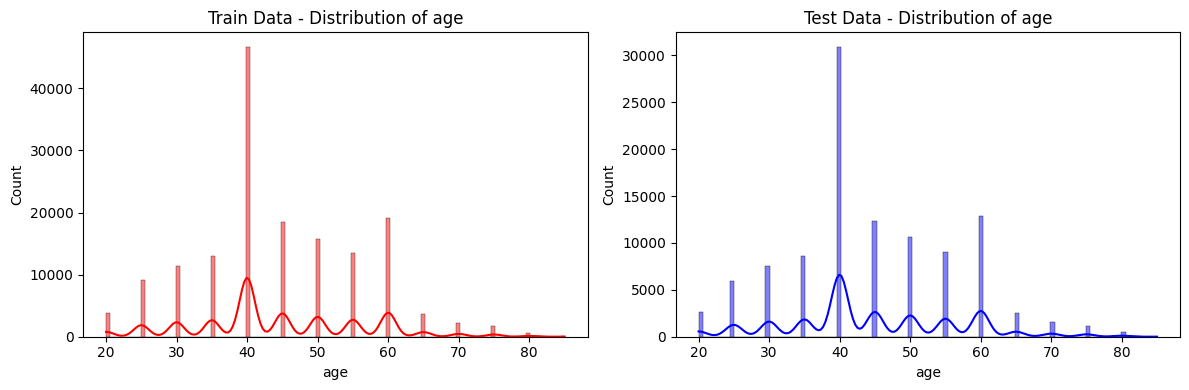

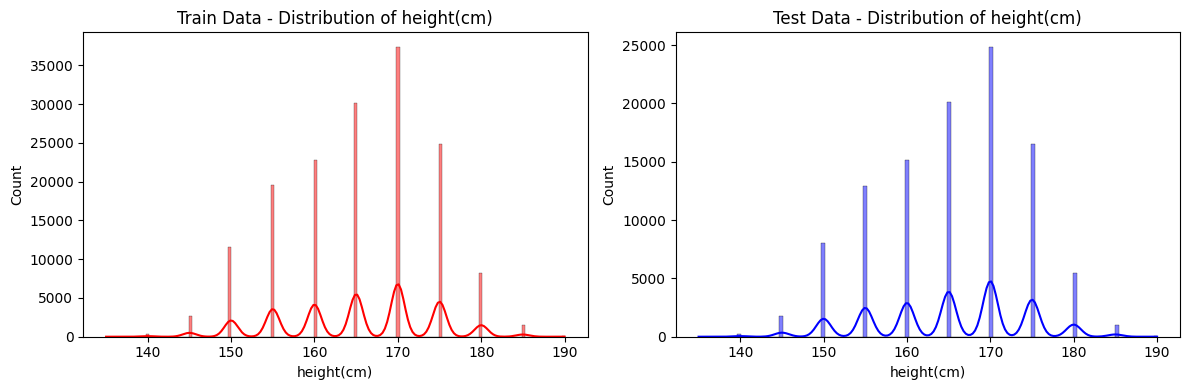

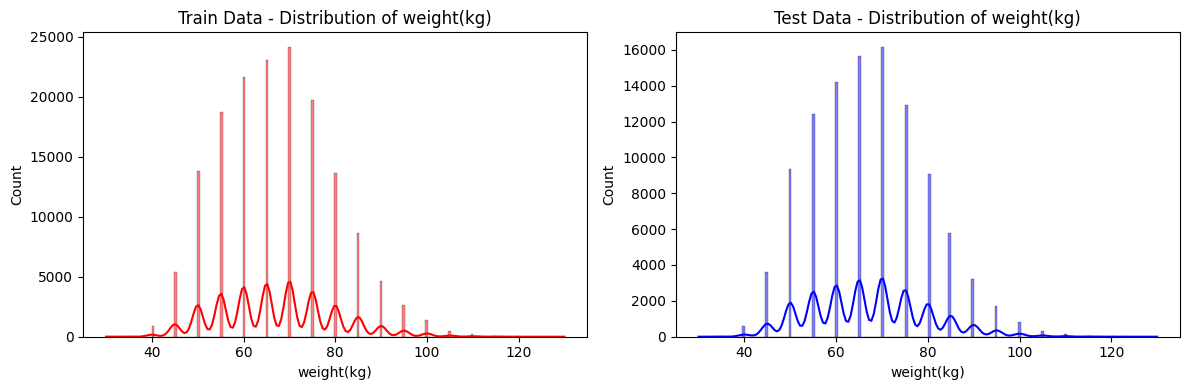

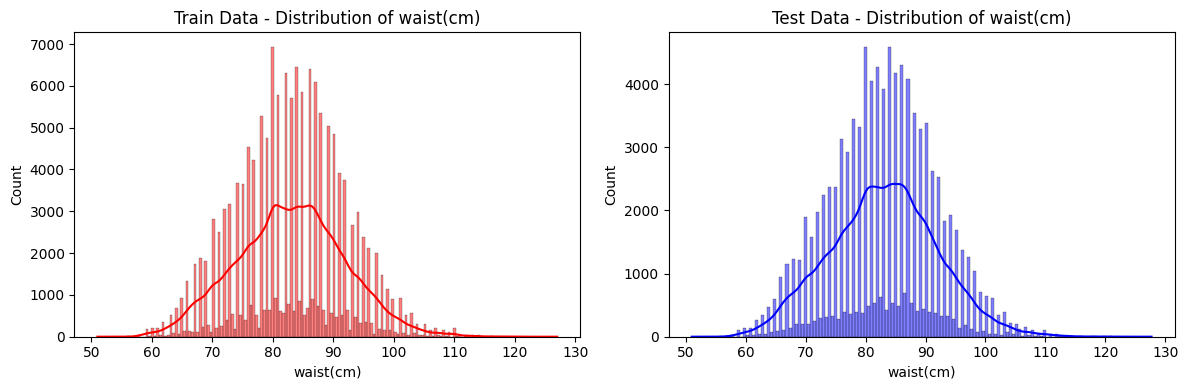

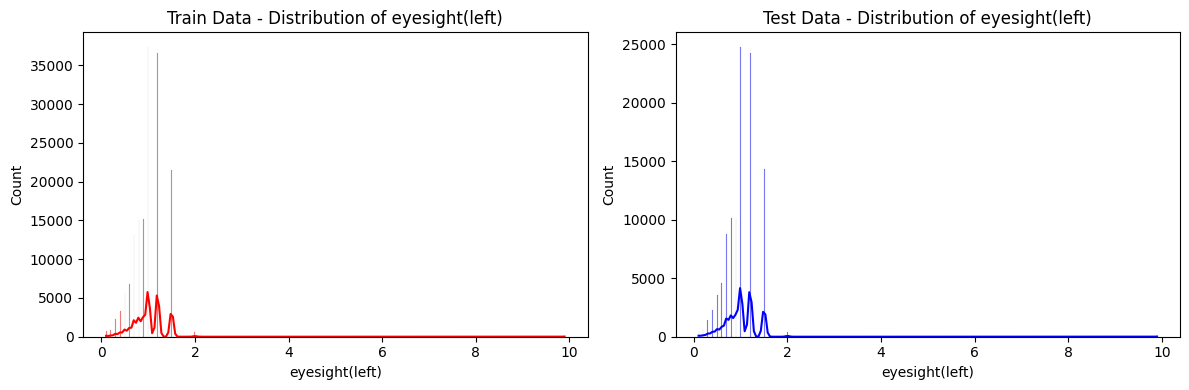

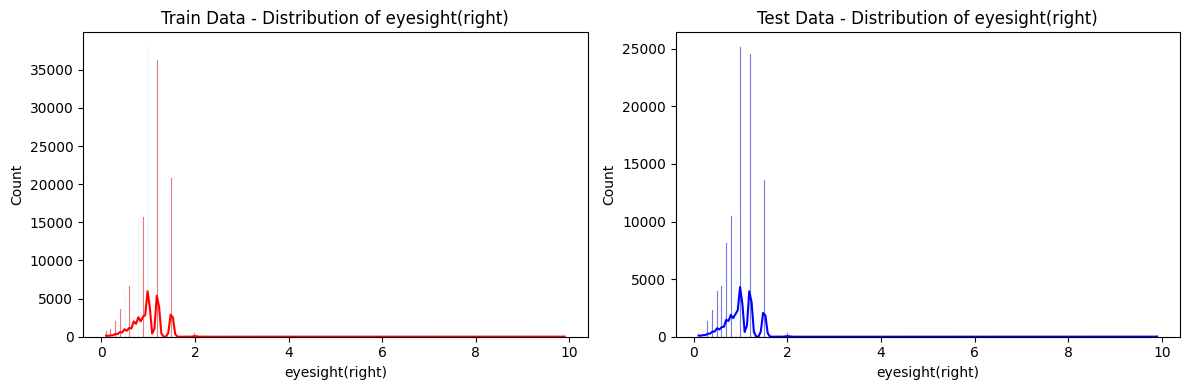

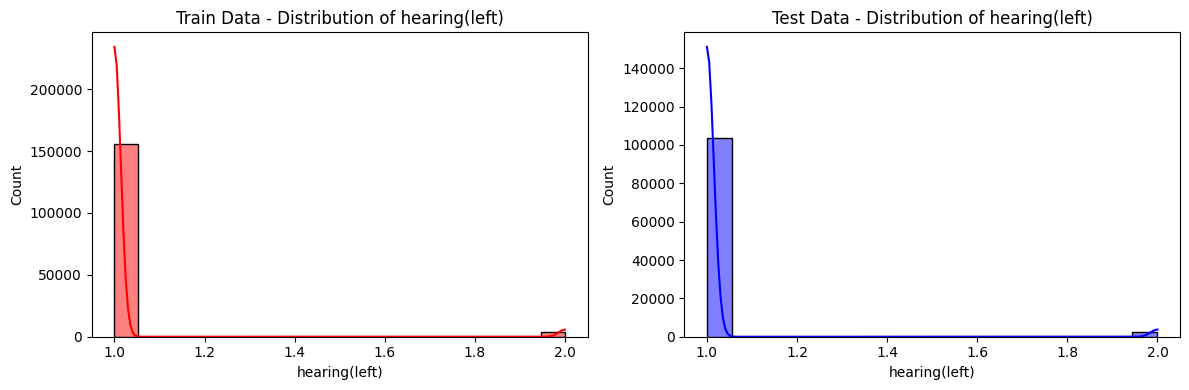

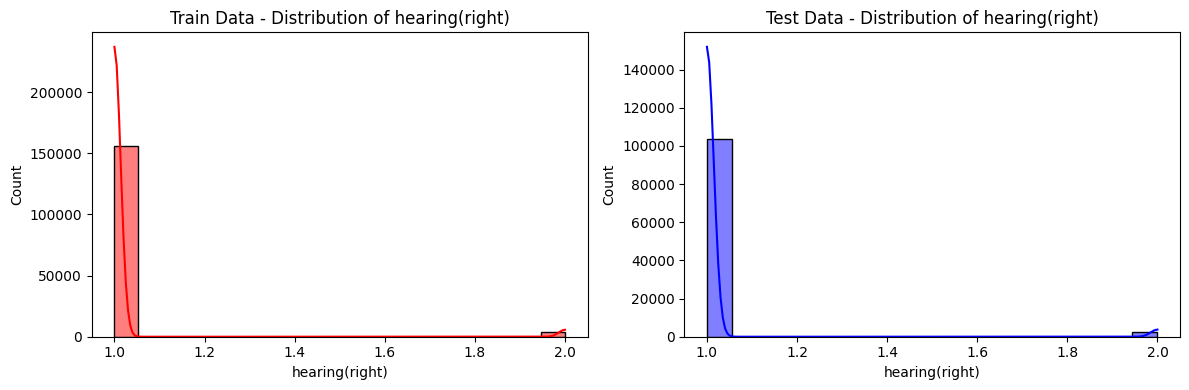

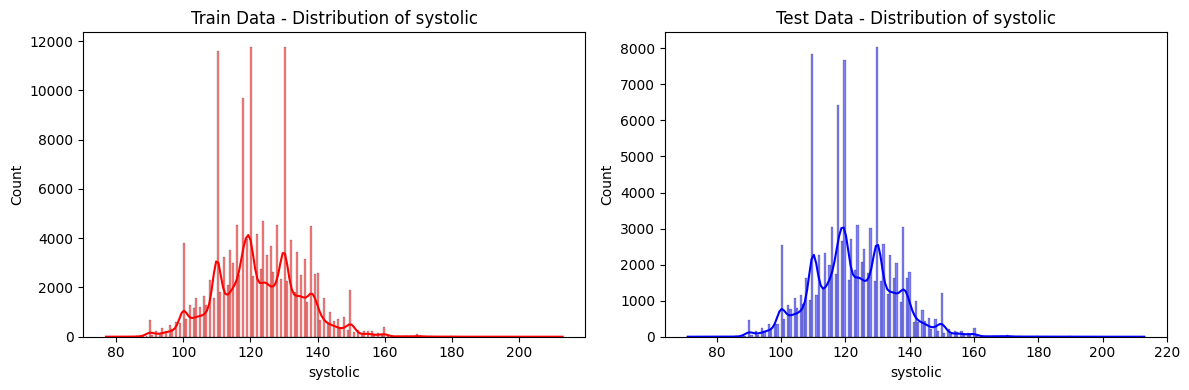

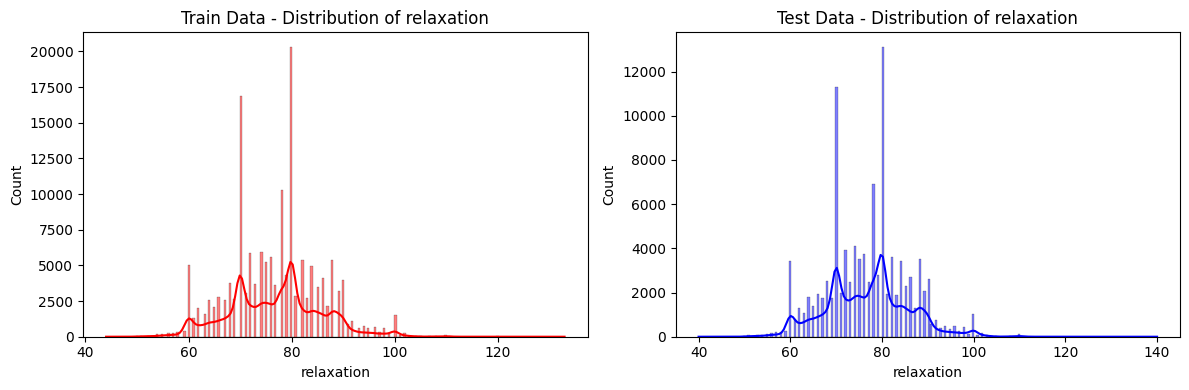

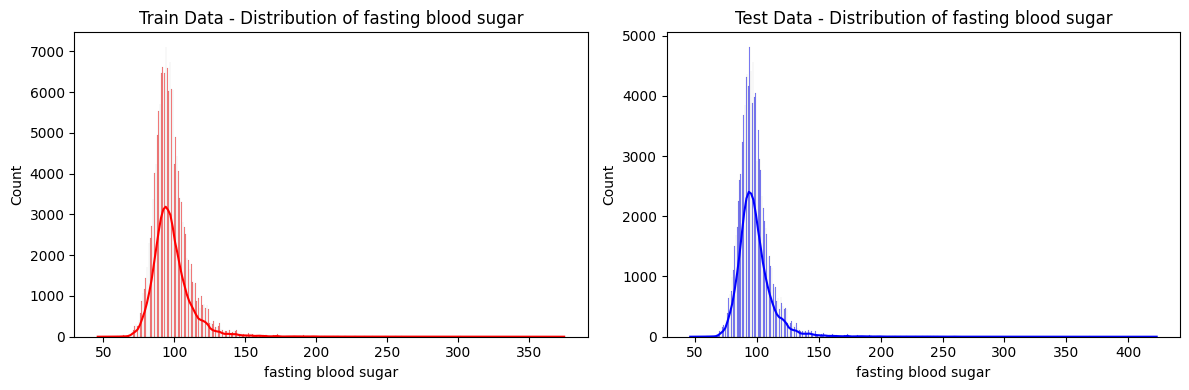

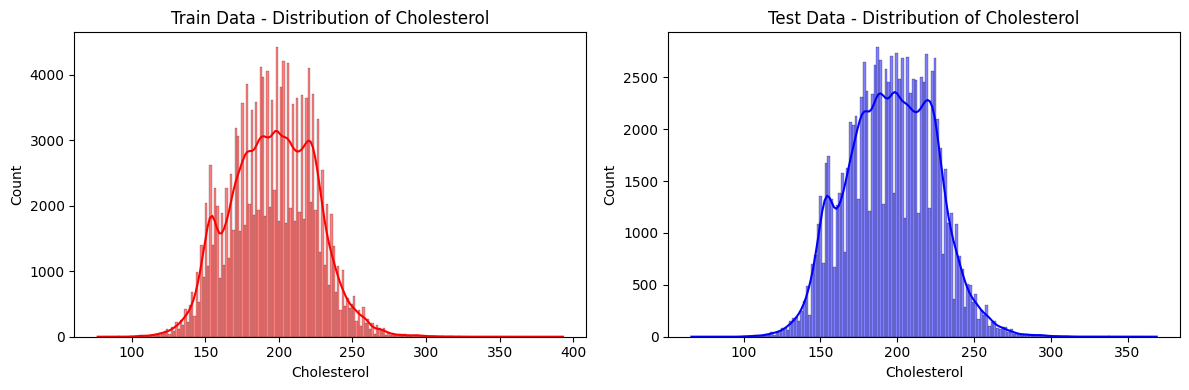

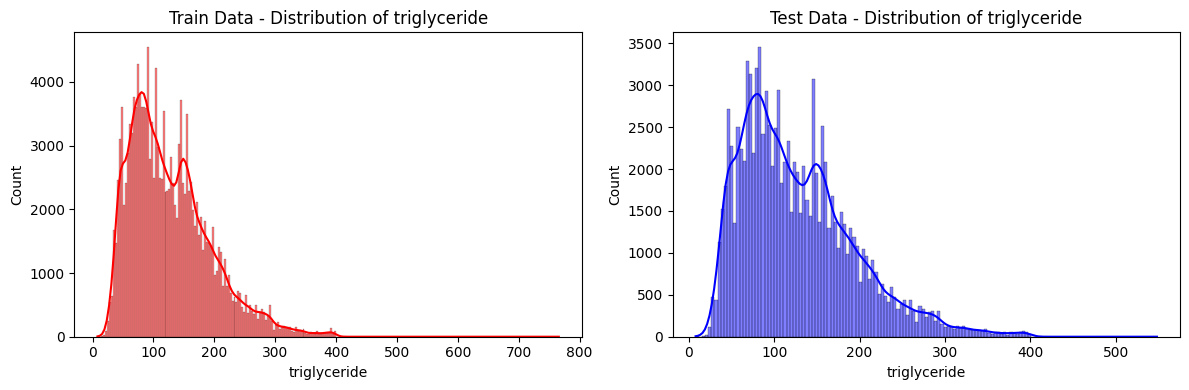

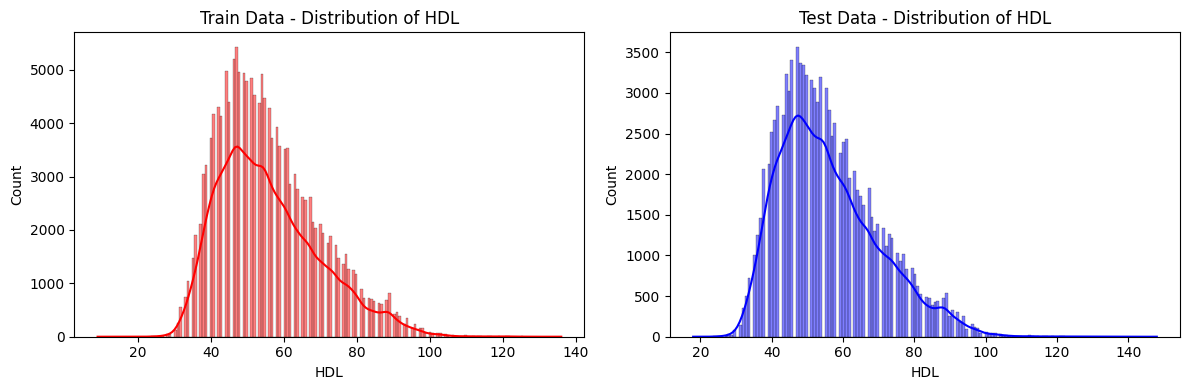

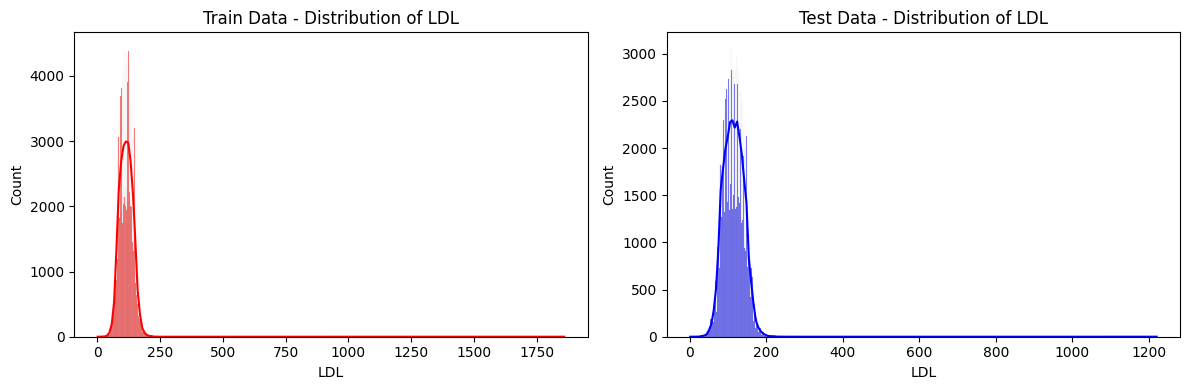

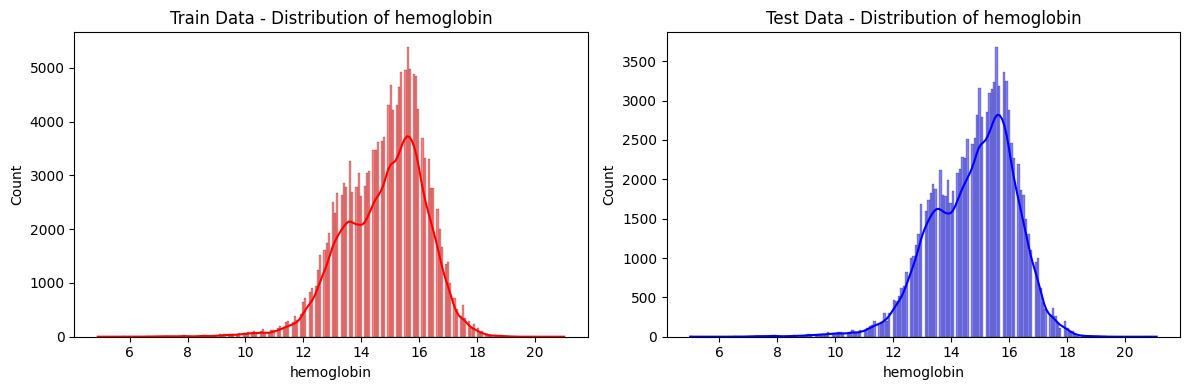

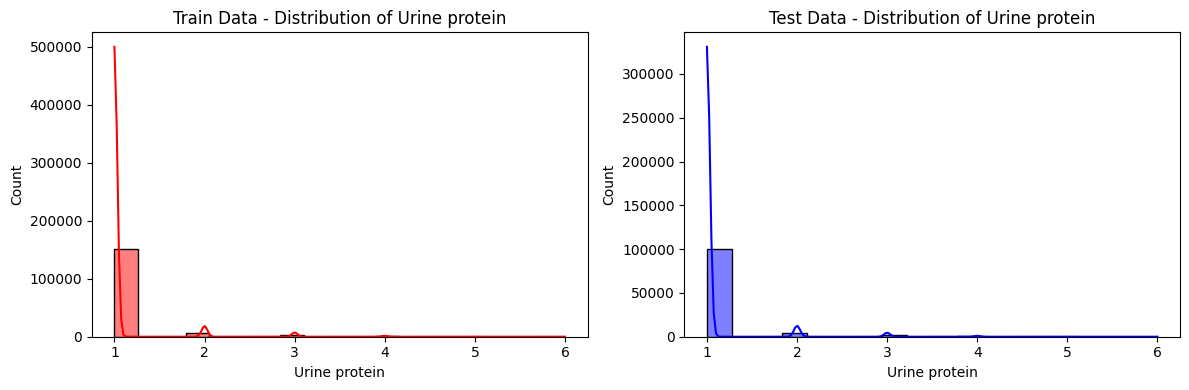

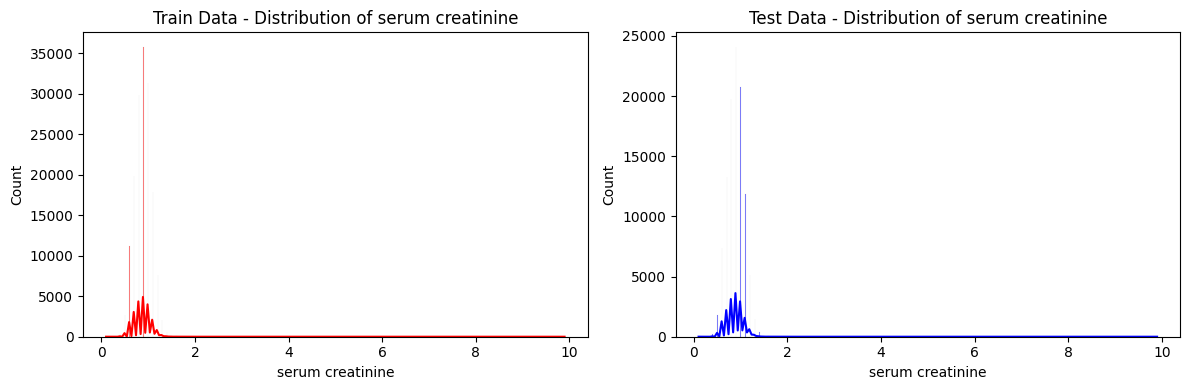

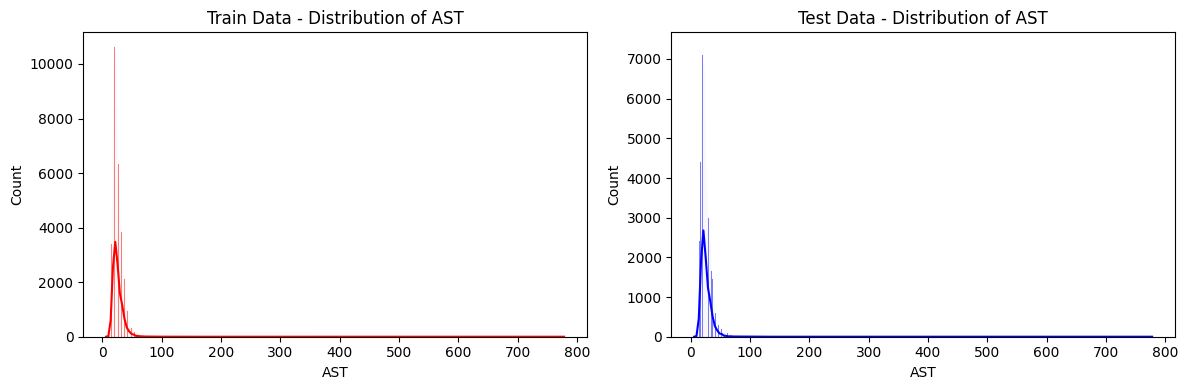

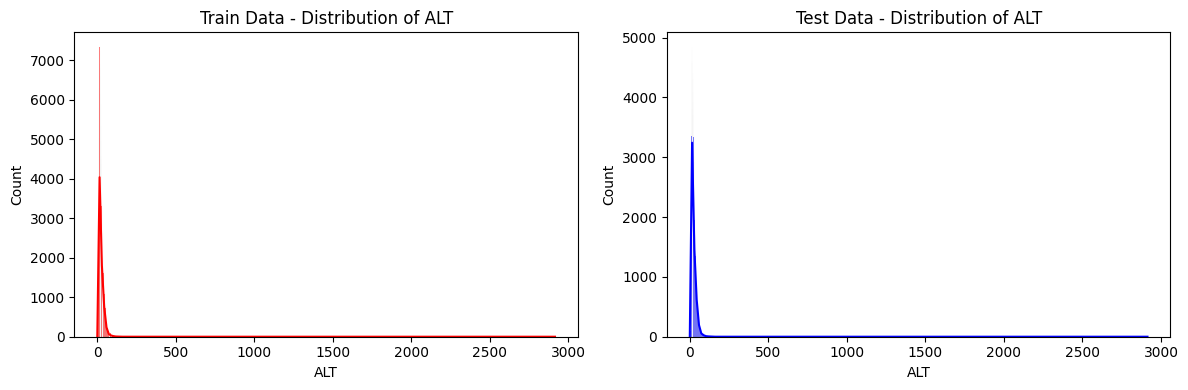

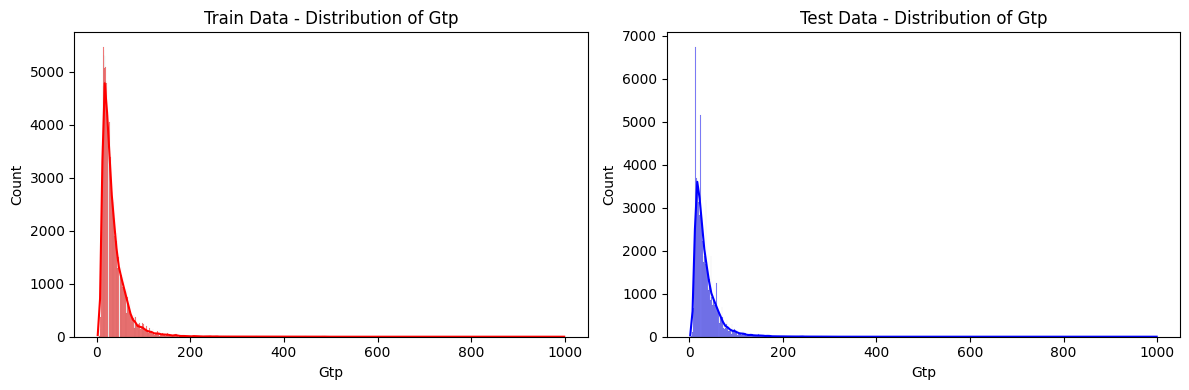

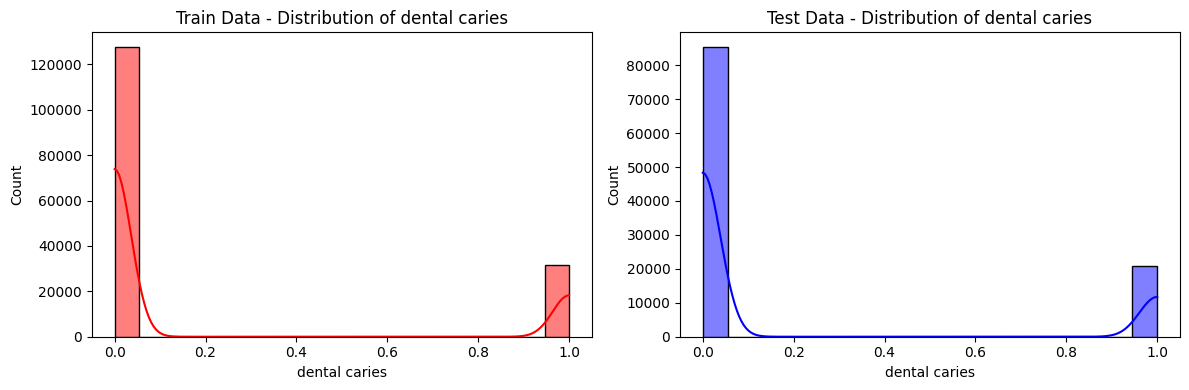

In [11]:
for feature in features:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(train_df[feature], kde=True, color='red')
    plt.title(f'Train Data - Distribution of {feature}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(test_df[feature], kde=True, color='blue')
    plt.title(f'Test Data - Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()


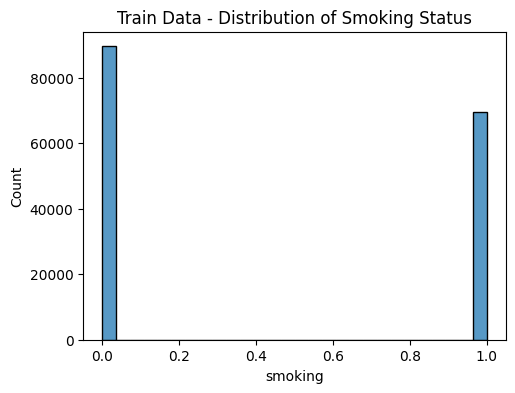

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train_df["smoking"])
plt.title("Train Data - Distribution of Smoking Status")
plt.show()

## 2. Identify outliers

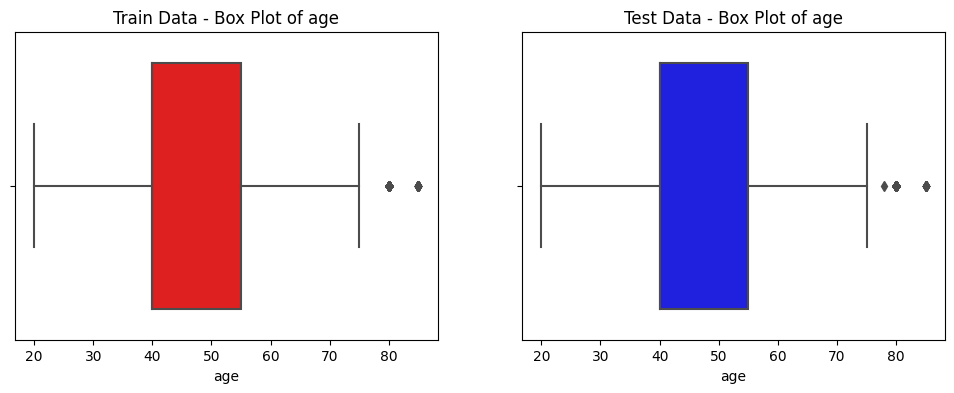

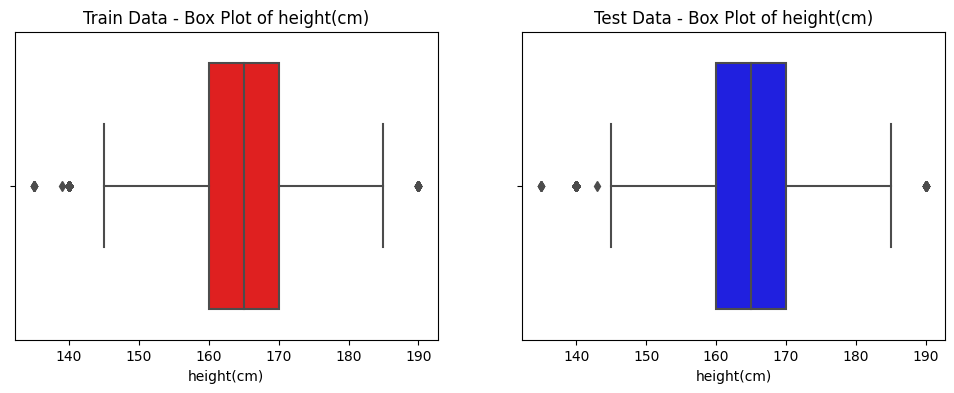

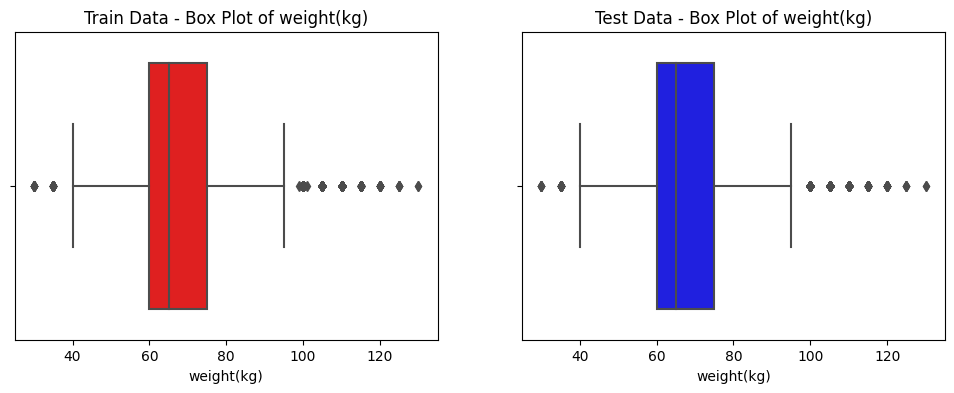

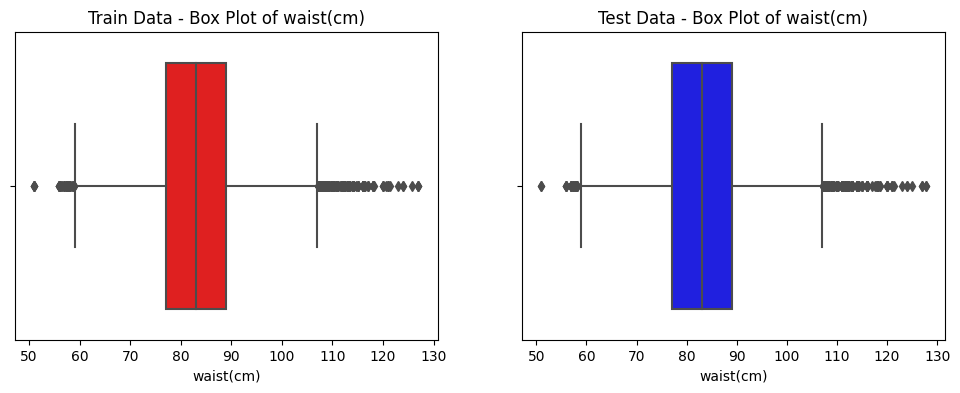

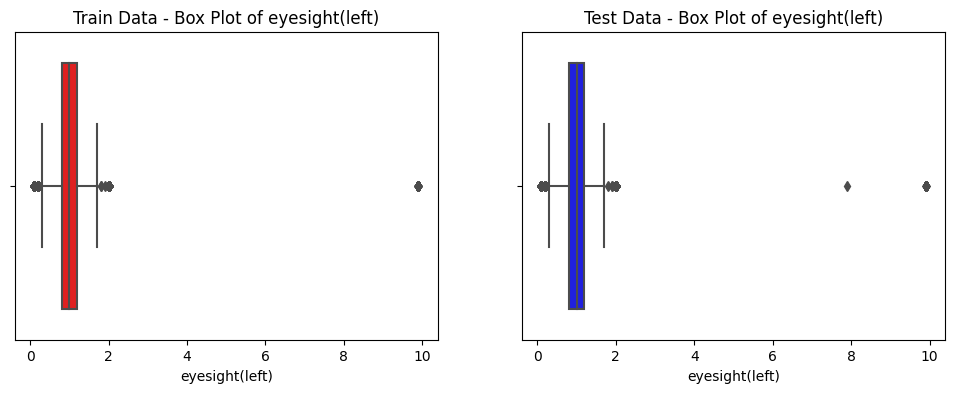

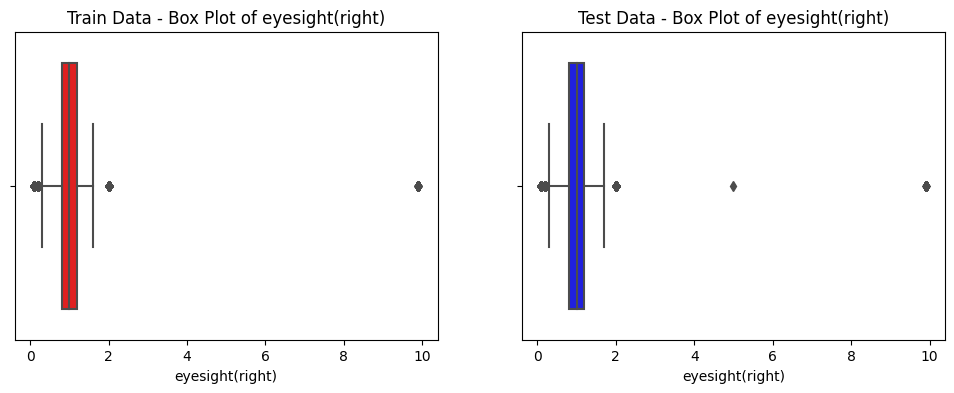

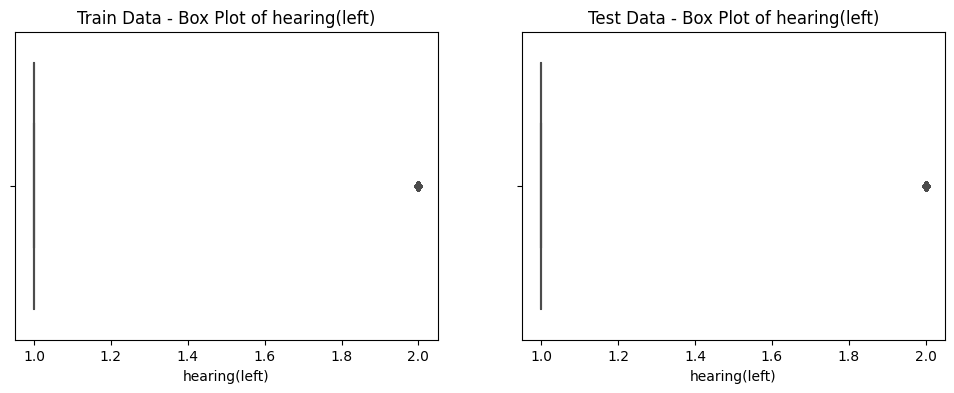

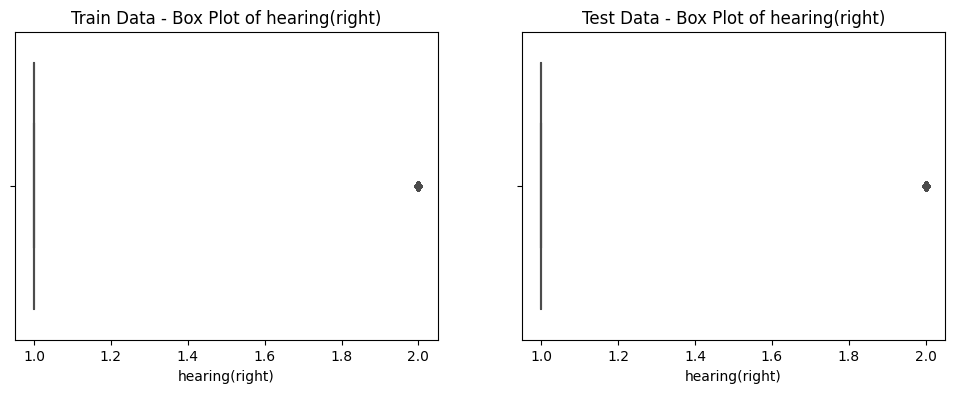

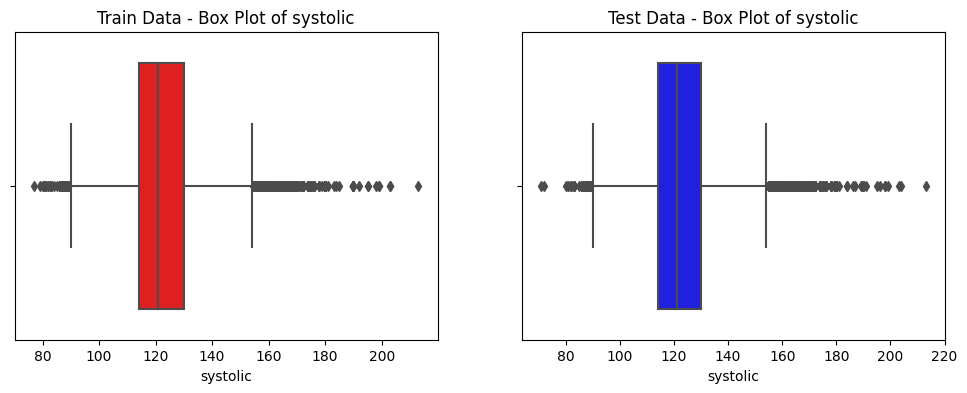

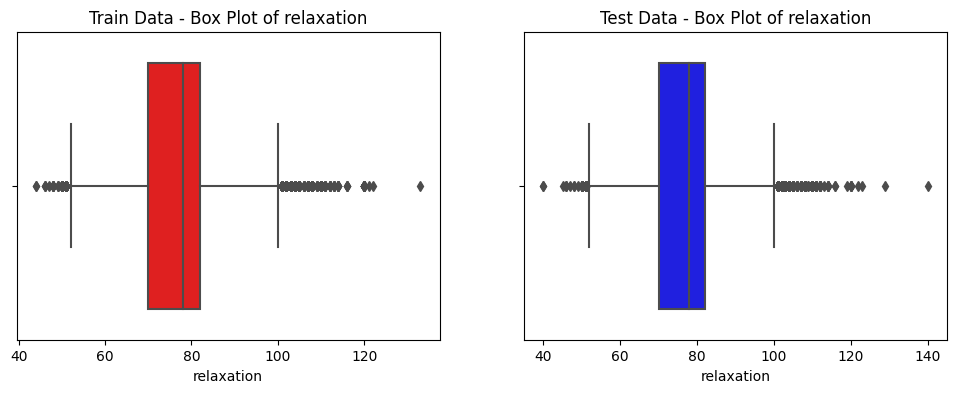

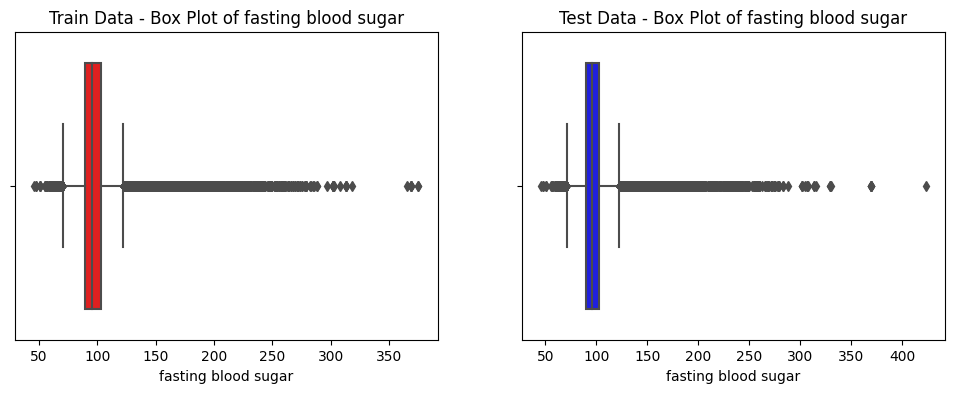

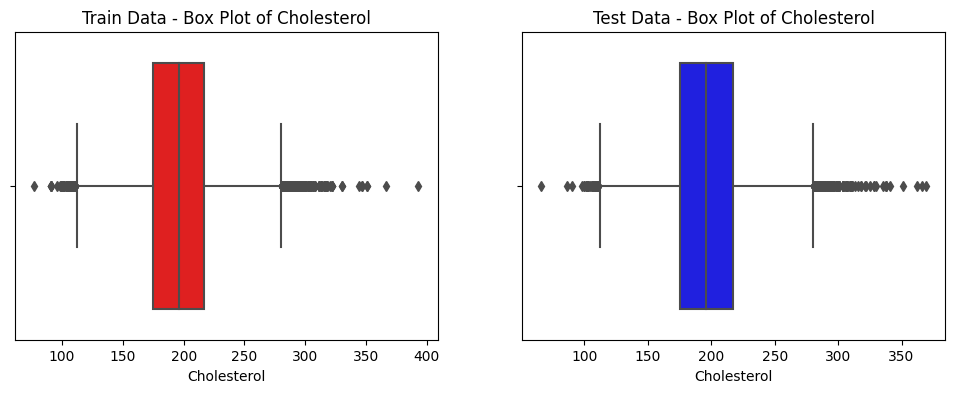

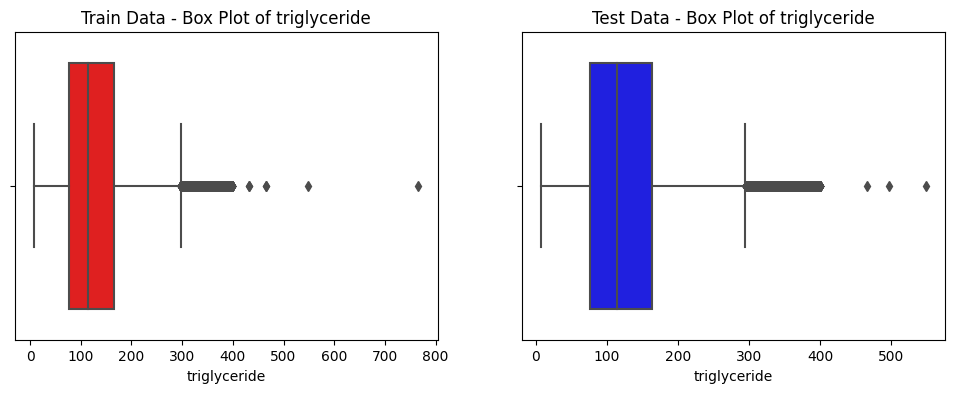

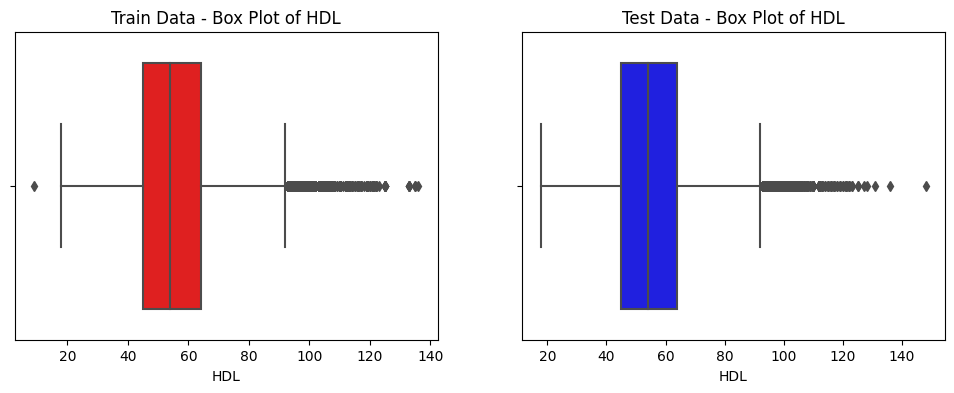

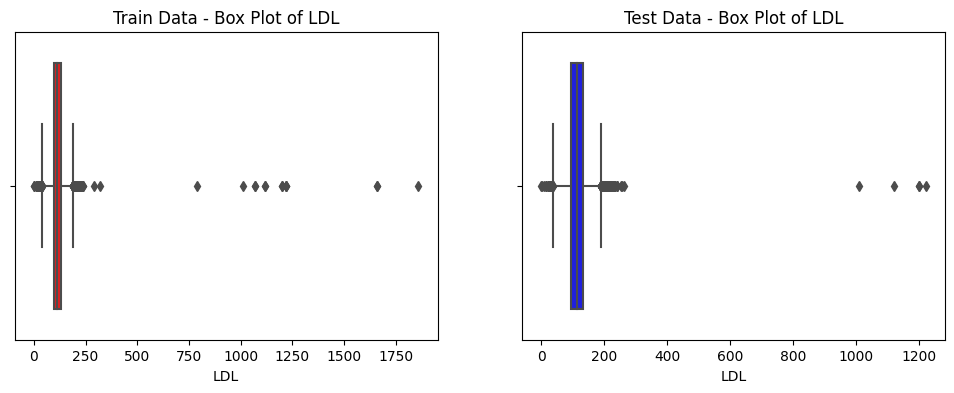

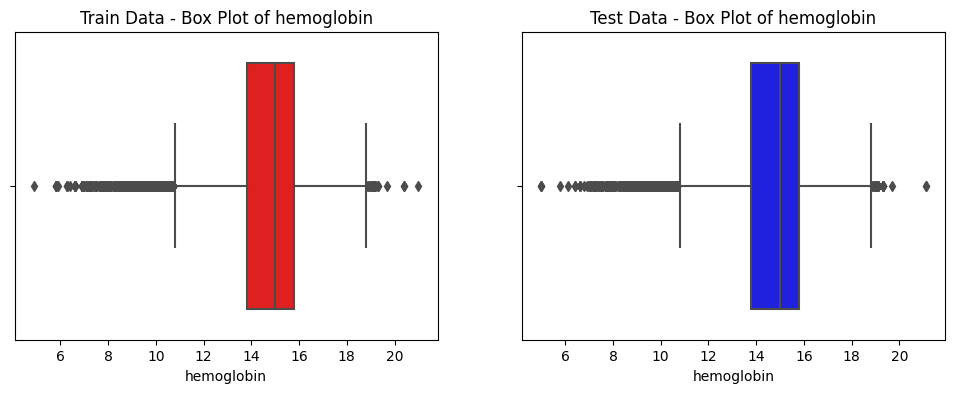

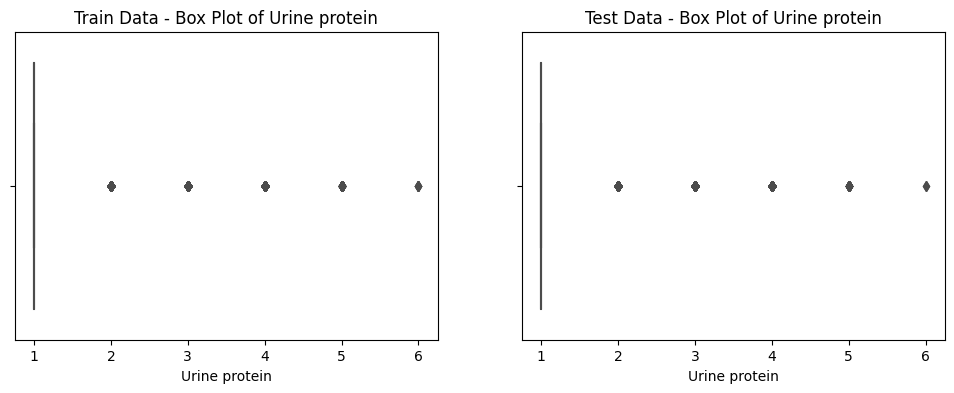

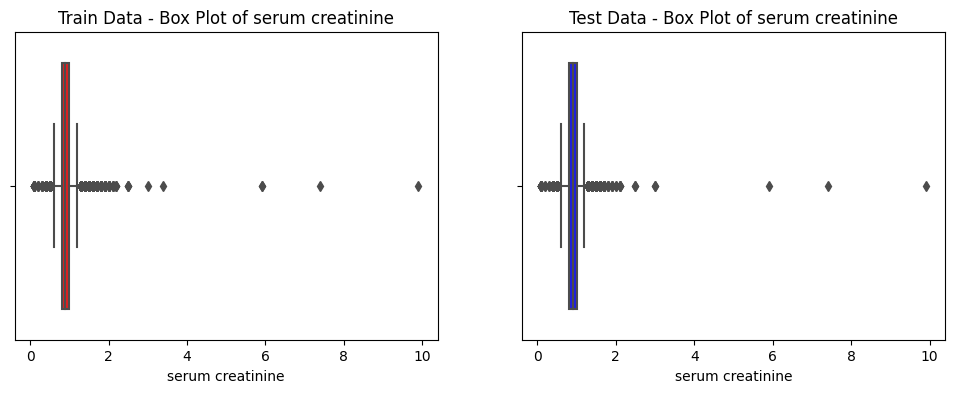

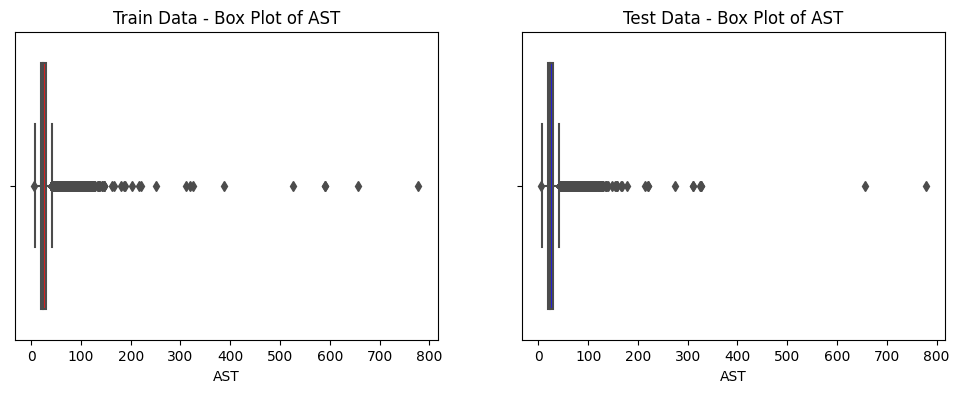

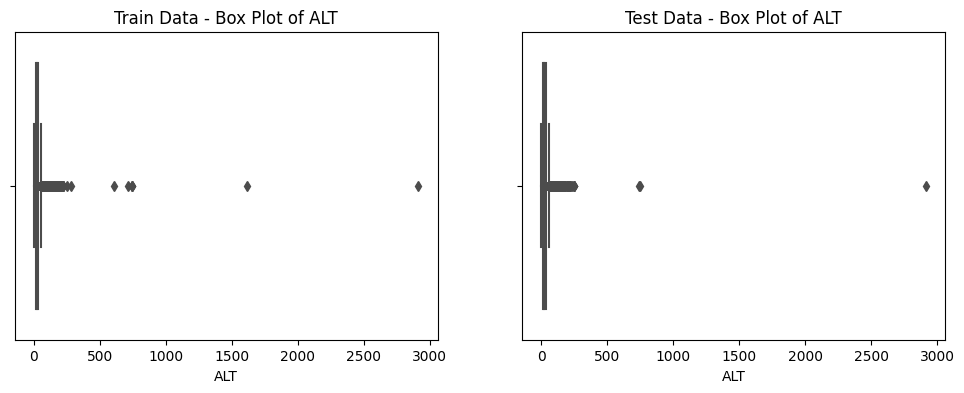

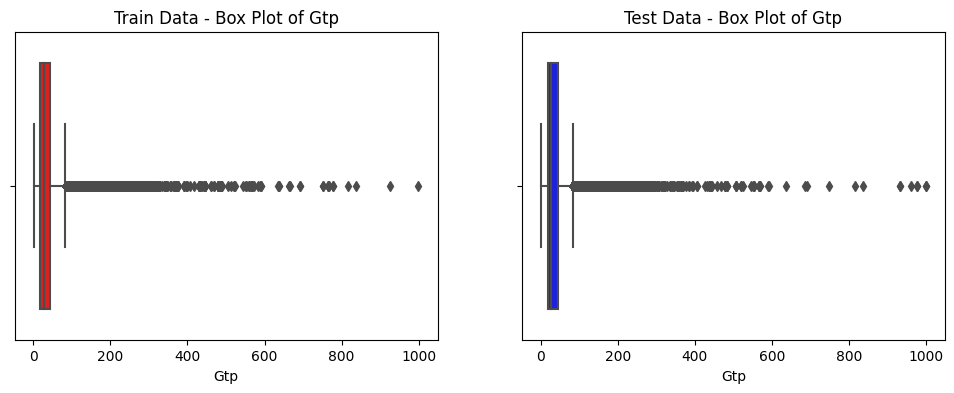

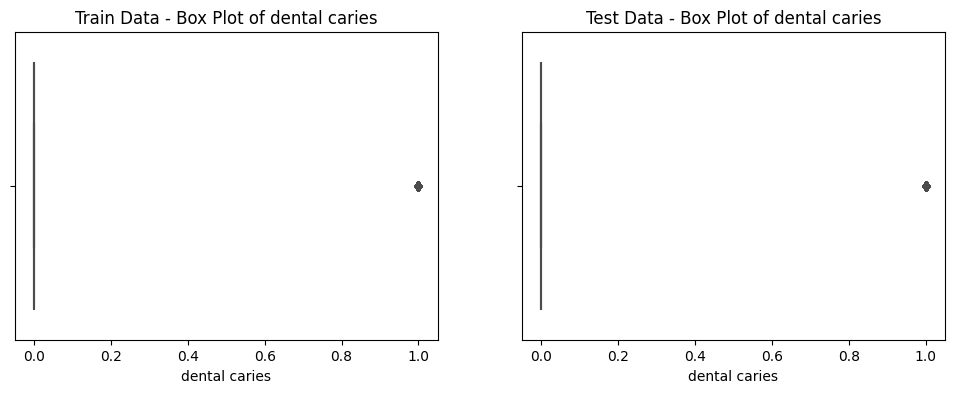

In [13]:
for feature in features:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.boxplot(x=train_df[feature], color='red')
    plt.title(f'Train Data - Box Plot of {feature}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=test_df[feature], color='blue')
    plt.title(f'Test Data - Box Plot of {feature}')
    plt.show()    

## 3. Correlation Matrix

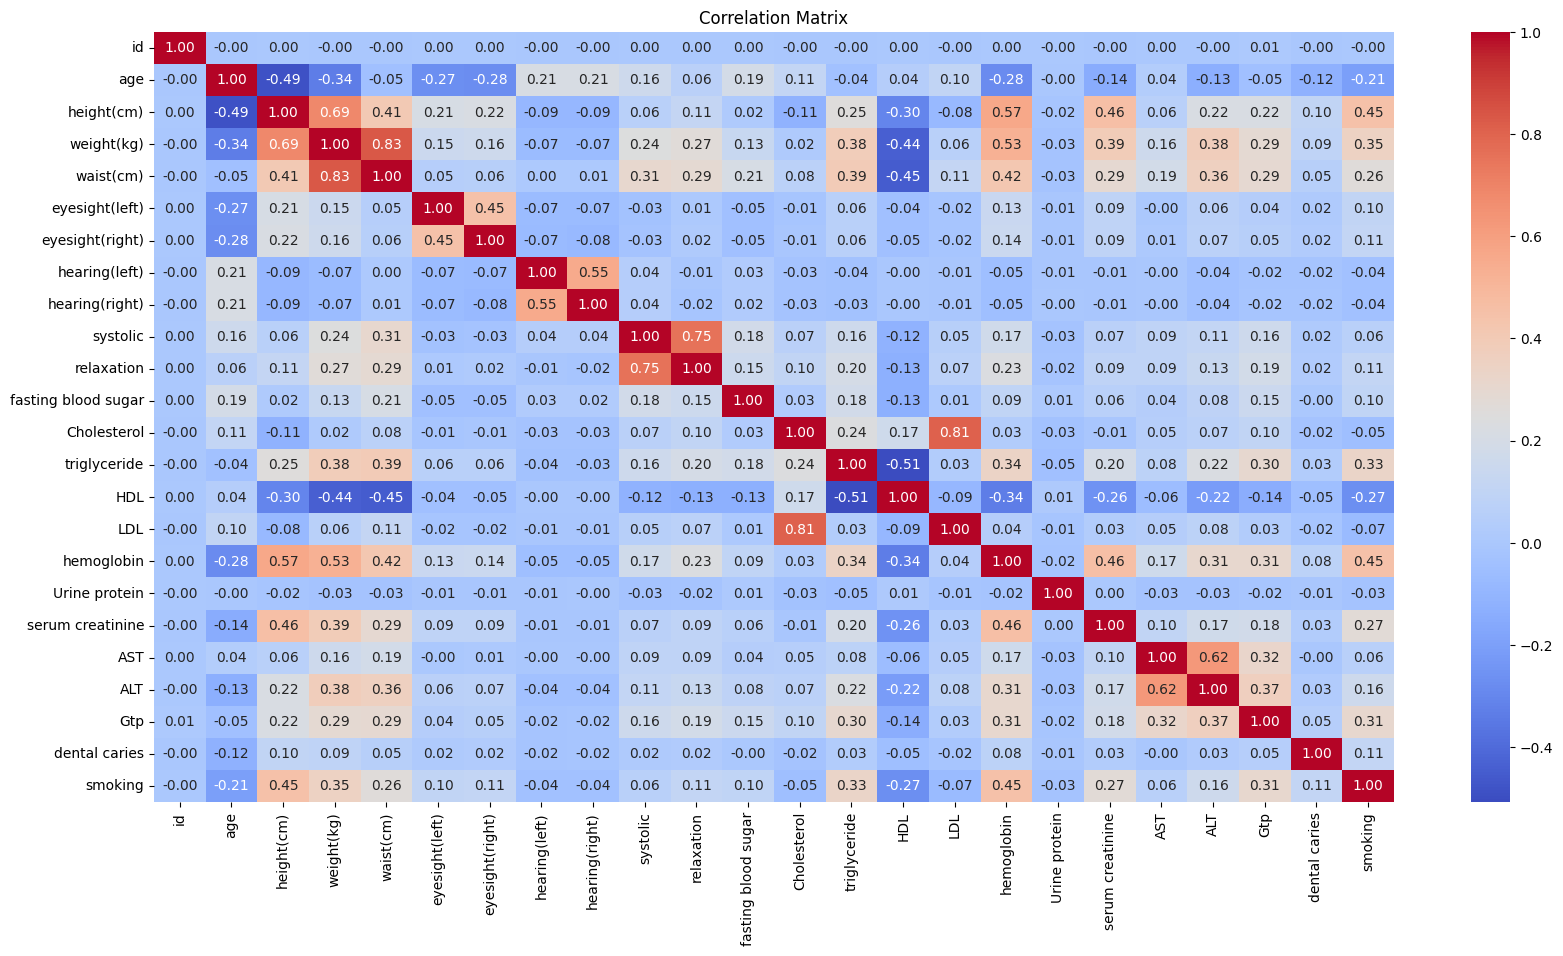

In [14]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Cholesterol vs LDL are highly correlated = 0.81
Height and Weight are highly correlated = 0.69
Weight and Waist are highly correlated = 0.83
AST and ALT are highly correlated = 0. 63

=> May cause multicollinearity issues
=> XGBoost

# Modelling

## XGBoost

In [15]:
# Set the hyperparameter tuning options
optuna_switch = 'on' 
opt_count = 5  
num_choose = 5

In [16]:
if opt_count < num_choose:
    num_choose = opt_count

In [17]:
# Define the objective function
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'alpha': trial.suggest_uniform('alpha', 0.0, 10.0),
        'lambda': trial.suggest_uniform('lambda', 0.0, 10.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3)
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    bst = xgb.train(params, dtrain, num_boost_round=100)
    y_pred = bst.predict(dtest)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    
    return roc_auc, logloss

In [18]:
if optuna_switch == 'on':
    study = optuna.create_study(directions=['maximize', 'minimize'])  # Two directions for ROC AUC and log loss
    study.optimize(objective, n_trials=opt_count, n_jobs=1)
    
    # Choose the top `num_choose` best trials
    num_choose = 10
    top_trials = study.trials_dataframe()
    top_trials['values_1'] = pd.to_numeric(top_trials['values_1'], errors='coerce')  # Convert values_1 to numeric
    top_trials = top_trials.nlargest(num_choose, "values_1")  # Sort based on log loss (values_1)
    top_params = top_trials[['params_alpha', 'params_booster', 'params_colsample_bytree', 'params_lambda', 'params_learning_rate', 'params_max_depth', 'params_min_child_weight', 'params_subsample']].to_dict(orient='records')


[I 2023-11-16 17:57:33,655] A new study created in memory with name: no-name-de31cf1b-f570-43ec-8555-6869240283a0
/tmp/ipykernel_32/714381053.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'alpha': trial.suggest_uniform('alpha', 0.0, 10.0),
/tmp/ipykernel_32/714381053.py:

[17:57:43] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2023-11-16 17:57:44,575] Trial 1 finished with values: [0.7848304833928628, 0.5723034587288701] and parameters: {'booster': 'gblinear', 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.40251976119975763, 'colsample_bytree': 0.9249845517688275, 'alpha': 0.5423293042083643, 'lambda': 9.841909905480437, 'learning_rate': 0.2513838910840632}. 
/tmp/ipykernel_32/714381053.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:11: FutureWarning: suggest_uniform has be

[17:57:44] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2023-11-16 17:57:45,746] Trial 2 finished with values: [0.6992060706962979, 0.6537520854419357] and parameters: {'booster': 'gblinear', 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.7865135793085704, 'colsample_bytree': 0.7142732344831592, 'alpha': 6.562875242933407, 'lambda': 7.715397987978278, 'learning_rate': 0.21470629121205656}. 
/tmp/ipykernel_32/714381053.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:11: FutureWarning: suggest_uniform has bee

[17:57:45] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2023-11-16 17:57:46,927] Trial 3 finished with values: [0.6996439795898802, 0.6619608489276527] and parameters: {'booster': 'gblinear', 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.305319584614163, 'colsample_bytree': 0.4564939867945793, 'alpha': 6.1399231743736635, 'lambda': 7.139856356768449, 'learning_rate': 0.08706796256216025}. 
/tmp/ipykernel_32/714381053.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
/tmp/ipykernel_32/714381053.py:11: FutureWarning: suggest_uniform has bee

[17:57:47] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2023-11-16 17:57:48,169] Trial 4 finished with values: [0.6993708041400233, 0.6414086777702336] and parameters: {'booster': 'gblinear', 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6522880019726048, 'colsample_bytree': 0.919732330782835, 'alpha': 4.104653549353193, 'lambda': 1.236261431219161, 'learning_rate': 0.2129965126999563}. 


In [19]:
top_trials.head()


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_subsample,system_attrs_nsga2:generation,state
3,3,0.699644,0.661961,2023-11-16 17:57:45.747158,2023-11-16 17:57:46.926751,0 days 00:00:01.179593,6.139923,gblinear,0.456494,7.139856,0.087068,4,2,0.305320,0,COMPLETE
2,2,0.699206,0.653752,2023-11-16 17:57:44.576726,2023-11-16 17:57:45.745899,0 days 00:00:01.169173,6.562875,gblinear,0.714273,7.715398,0.214706,9,7,0.786514,0,COMPLETE
4,4,0.699371,0.641409,2023-11-16 17:57:46.928055,2023-11-16 17:57:48.169547,0 days 00:00:01.241492,4.104654,gblinear,0.919732,1.236261,0.212997,7,2,0.652288,0,COMPLETE
1,1,0.784830,0.572303,2023-11-16 17:57:43.130586,2023-11-16 17:57:44.575484,0 days 00:00:01.444898,0.542329,gblinear,0.924985,9.841910,0.251384,1,5,0.402520,0,COMPLETE
0,0,0.863537,0.447100,2023-11-16 17:57:33.657637,2023-11-16 17:57:43.129207,0 days 00:00:09.471570,3.701630,gbtree,0.798083,4.663505,0.253757,6,4,0.707166,0,COMPLETE


Top-1 Parameters: {'params_alpha': 6.1399231743736635, 'params_booster': 'gblinear', 'params_colsample_bytree': 0.4564939867945793, 'params_lambda': 7.139856356768449, 'params_learning_rate': 0.08706796256216025, 'params_max_depth': 4, 'params_min_child_weight': 2, 'params_subsample': 0.305319584614163}
[17:57:48] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

Top-2 Parameters: {'params_alpha': 6.562875242933407, 'params_booster': 'gblinear', 'params_colsample_bytree': 0.7142732344831592, 'params_lambda': 7.715397987978278, 'params_learning_rate': 0.21470629121205656, 'params_max_depth': 9, 'params_min_child_weight': 7, 'params_subsample': 0.7865135793085704}
[17:58:08] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_lea

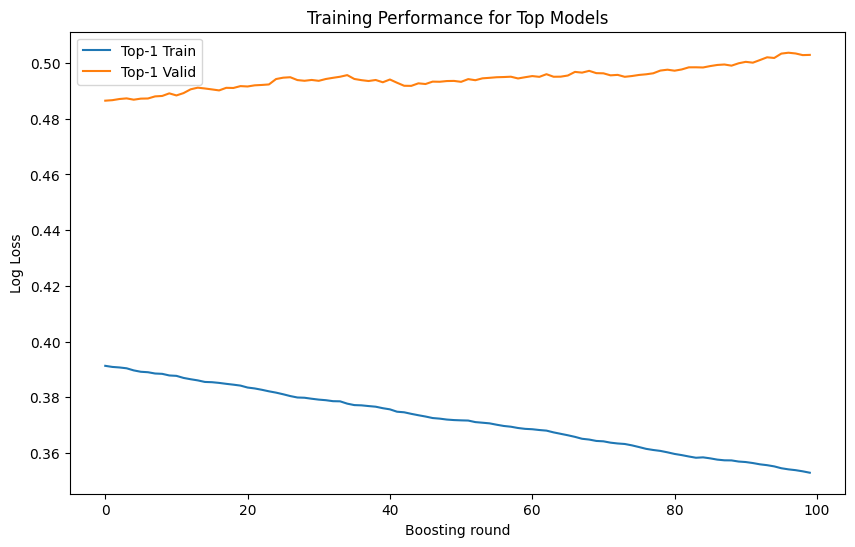

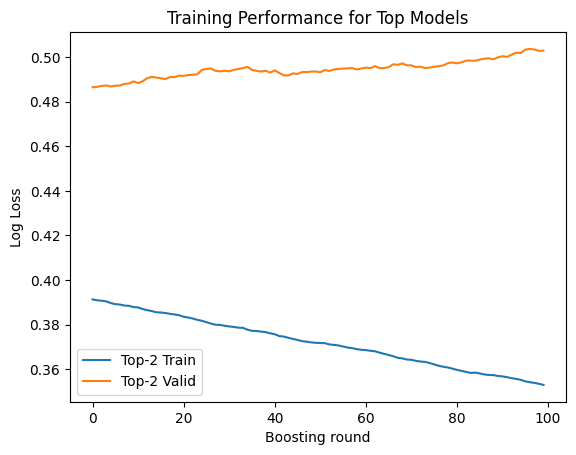

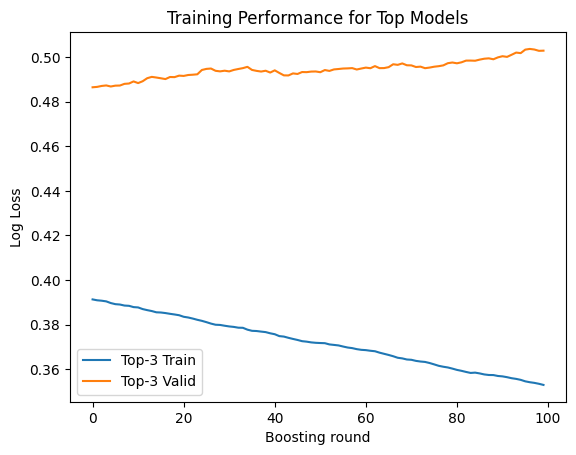

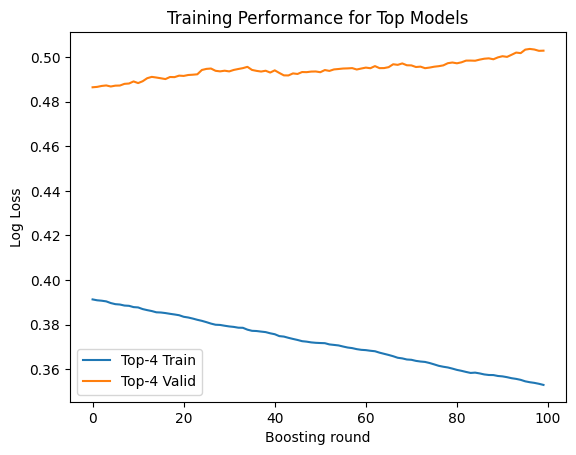

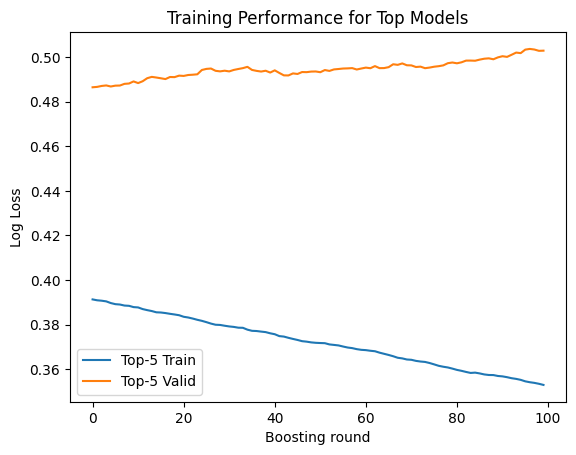

In [20]:
# List to store training metrics for each model
training_metrics = []

for i, params in enumerate(top_params, start=1):
    print(f"Top-{i} Parameters: {params}")
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create DMatrix objects for training and testing data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Initialize the XGBoost model with the provided parameters
    model = xgb.train(params, dtrain, num_boost_round=100)
    
    # Lists to store training and validation log loss values during training
    training_logloss = []
    validation_logloss = []
    
    for i in range(100):
        model.update(dtrain, i)
        y_pred_train = model.predict(dtrain)
        y_pred_valid = model.predict(dtest)
        
        logloss_train = log_loss(y_train, y_pred_train)
        logloss_valid = log_loss(y_test, y_pred_valid)
        
        training_logloss.append(logloss_train)
        validation_logloss.append(logloss_valid)
    
    # Append the training metrics to the list
    training_metrics.append({'training_logloss': training_logloss, 'validation_logloss': validation_logloss})
    
# Plot the training performance for all top models
plt.figure(figsize=(10, 6))
for i, metrics in enumerate(training_metrics, start=1):
    plt.plot(metrics['training_logloss'], label=f'Top-{i} Train')
    plt.plot(metrics['validation_logloss'], label=f'Top-{i} Valid')

    plt.ylabel('Log Loss')
    plt.xlabel('Boosting round')
    plt.title('Training Performance for Top Models')
    plt.legend()
    plt.show()

Training Log Loss: It decreasing indicates that the model is learning to fit the training data well. The decreasing log loss shows that the model is getting better at predicting the training data, which is expected during the training phase.
Validation Log Loss: It increasing indicates that the model is overfitting the training data. The rising log loss on the validation set suggests that the model's performance on unseen data is deteriorating, which is a common sign of overfitting.

=> consider strategies to mitigate overfitting: using regularization techniques.

[0]	train-logloss:0.67460	valid-logloss:0.67480
[1]	train-logloss:0.65872	valid-logloss:0.65919


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[2]	train-logloss:0.64342	valid-logloss:0.64415
[3]	train-logloss:0.62983	valid-logloss:0.63073
[4]	train-logloss:0.61941	valid-logloss:0.62075
[5]	train-logloss:0.60671	valid-logloss:0.60829
[6]	train-logloss:0.59979	valid-logloss:0.60153
[7]	train-logloss:0.59013	valid-logloss:0.59202
[8]	train-logloss:0.58207	valid-logloss:0.58415
[9]	train-logloss:0.57485	valid-logloss:0.57699
[10]	train-logloss:0.56642	valid-logloss:0.56876
[11]	train-logloss:0.55948	valid-logloss:0.56192
[12]	train-logloss:0.55343	valid-logloss:0.55611
[13]	train-logloss:0.54682	valid-logloss:0.54969
[14]	train-logloss:0.54141	valid-logloss:0.54434
[15]	train-logloss:0.53628	valid-logloss:0.53940
[16]	train-logloss:0.53106	valid-logloss:0.53433
[17]	train-logloss:0.52691	valid-logloss:0.53031
[18]	train-logloss:0.52388	valid-logloss:0.52738
[19]	train-logloss:0.51920	valid-logloss:0.52290
[20]	train-logloss:0.51512	valid-logloss:0.51901
[21]	train-logloss:0.51116	valid-logloss:0.51518
[22]	train-logloss:0.50771	v

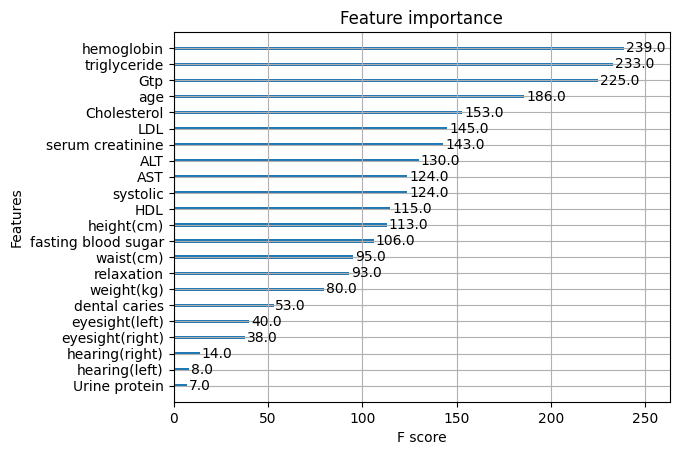

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.1482171849776969,
    'colsample_bytree': 0.5217617758087357,
    'gamma': 0.1,
    'alpha': 7.5778665094887465,
    'lambda': 7.078311703202407,
    'learning_rate': 0.06398226248389557,
    'eval_metric': 'logloss'
}

# Create DMatrix objects for training and validation data
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Train the XGBoost model
num_round = 100
model = xgb.train(params, dtrain, num_round, [(dtrain, 'train'), (dvalid, 'valid')])

# Evaluate the model
y_pred = model.predict(dvalid)
roc_auc = roc_auc_score(y_valid, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Visualize feature importance

xgb.plot_importance(model)
plt.show()

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-logloss:0.68840	valid-logloss:0.68861
[1]	train-logloss:0.68403	valid-logloss:0.68441
[2]	train-logloss:0.67977	valid-logloss:0.68035
[3]	train-logloss:0.67534	valid-logloss:0.67611
[4]	train-logloss:0.67102	valid-logloss:0.67196
[5]	train-logloss:0.66687	valid-logloss:0.66800
[6]	train-logloss:0.66295	valid-logloss:0.66424
[7]	train-logloss:0.65944	valid-logloss:0.66087
[8]	train-logloss:0.65592	valid-logloss:0.65751
[9]	train-logloss:0.65214	valid-logloss:0.65390
[10]	train-logloss:0.64835	valid-logloss:0.65028
[11]	train-logloss:0.64471	valid-logloss:0.64679
[12]	train-logloss:0.64123	valid-logloss:0.64349
[13]	train-logloss:0.63762	valid-logloss:0.64005
[14]	train-logloss:0.63414	valid-logloss:0.63675
[15]	train-logloss:0.63070	valid-logloss:0.63350
[16]	train-logloss:0.62736	valid-logloss:0.63034
[17]	train-logloss:0.62415	valid-logloss:0.62731
[18]	train-logloss:0.62092	valid-logloss:0.62424
[19]	train-logloss:0.61776	valid-logloss:0.62124
[20]	train-logloss:0.61464	val

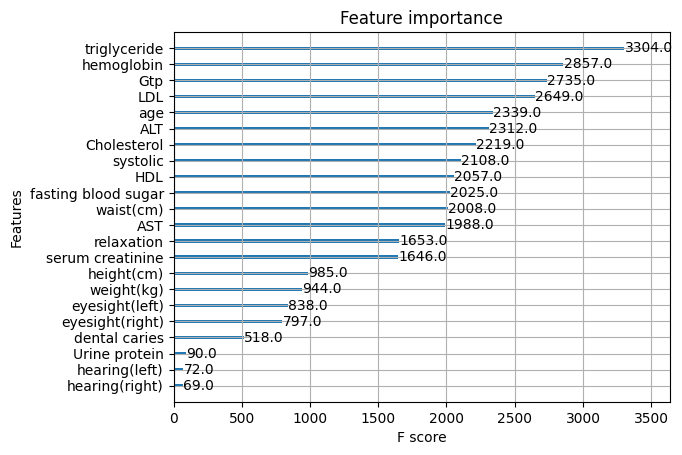

In [22]:
# Define the top-2 parameters you want to use
top_2_params = {
    'objective': 'binary:logistic',
    'max_depth': 10,
    'min_child_weight': 4,
    'subsample': 0.5352304500066158,
    'colsample_bytree': 0.8392629349510639,
    'gamma': 0.1,
    'alpha': 2.6715494671485365,
    'lambda': 6.545017188496152,
    'learning_rate': 0.012724600785978967,
    'eval_metric': 'logloss'
}

# Create DMatrix objects for training and validation data
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Train the XGBoost model
num_round = 100
model = xgb.train(top_2_params, dtrain, num_round, [(dtrain, 'train'), (dvalid, 'valid')])

# Evaluate the model
y_pred = model.predict(dvalid)
roc_auc = roc_auc_score(y_valid, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Visualize feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

In [23]:
# Ensembling
test_predictions = []

for params in top_params:
    dtest = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=100)
    y_pred_test = model.predict(dtest)
    test_predictions.append(y_pred_test)

# Calculate the average of the test predictions from all models
ensemble_test_predictions = np.mean(test_predictions, axis=0)

[18:00:07] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

[18:00:18] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

[18:00:26] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

[18:00:35] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

[18:00:43] WARNING: ../src/l

In [24]:
# Calculate the ROC AUC for the ensemble predictions
ensemble_roc_auc = roc_auc_score(y_test, ensemble_test_predictions)

print(f"Ensemble ROC AUC Score: {ensemble_roc_auc}")

Ensemble ROC AUC Score: 0.8604276877418768


In [25]:
num_folds=5
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store ROC AUC scores for each fold
roc_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{num_folds}')

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create DMatrix objects for training and validation data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Initialize the XGBoost model with the top parameters
    model = xgb.train(top_params[fold], dtrain, num_boost_round=100)

    # Get predictions on the validation data
    y_pred = model.predict(dval)

    # Calculate the ROC AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_pred)
    roc_auc_scores.append(roc_auc)
    print(f'ROC AUC: {roc_auc}')

# Calculate the mean ROC AUC score across all folds
mean_roc_auc = np.mean(roc_auc_scores)
print(f'Mean ROC AUC: {mean_roc_auc}')

Fold 1/5
[18:00:52] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

ROC AUC: 0.8607357526853866
Fold 2/5
[18:01:00] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

ROC AUC: 0.8640813088198724
Fold 3/5
[18:01:09] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.

ROC AUC: 0.8636607952010932
Fold 4/5
[18:01:17] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learnin

In [26]:
dtrain = xgb.DMatrix(X, label=y)
model = xgb.train(top_params[0], dtrain, num_boost_round=100)  # Use the parameters from the first fold

# Create a DMatrix for the test data
dtest = xgb.DMatrix(test_df.drop(columns=['id']))

y_test_pred = model.predict(dtest)

# Create a DataFrame for the submission file
submission = pd.DataFrame({'id': test_df['id'], 'smoking': y_test_pred})


[18:01:35] WARNING: ../src/learner.cc:767: 
Parameters: { "params_alpha", "params_booster", "params_colsample_bytree", "params_lambda", "params_learning_rate", "params_max_depth", "params_min_child_weight", "params_subsample" } are not used.



In [27]:
submission

,id,smoking
0,159256,0.535654
1,159257,0.417544
2,159258,0.462286
3,159259,0.014411
4,159260,0.655636
...,...,...
106166,265422,0.526298
106167,265423,0.648031
106168,265424,0.415185
106169,265425,0.182422


In [28]:
submission.to_csv('submission.csv', header=True, index=False)